In [1]:
# http://www.physics.usyd.edu.au/teach_res/mp/mscripts/
# ns_izh002.m
import collections
# Fast spiking cannot be reproduced as it requires modifications to the standard Izhi equation,
# which are expressed in this mod file.
# https://github.com/OpenSourceBrain/IzhikevichModel/blob/master/NEURON/izhi2007b.mod

from collections import OrderedDict
type2007 = collections.OrderedDict([
  #              C    k     vr  vt vpeak   a      b   c    d  celltype
  ('RS',        (100, 0.7,  -60, -40, 35, 0.03,   -2, -50,  100,  1)),
  ('IB',        (150, 1.2,  -75, -45, 50, 0.01,   5, -56,  130,   2)),
  ('CH',        (50,  1.5,  -60, -40, 25, 0.03,   1, -40,  150,   3)),
  ('LTS',       (100, 1.0,  -56, -42, 40, 0.03,   8, -53,   20,   4)),
  ('FS',        (20,  1.0,  -55, -40, 25, 0.2,   -2, -45,  -55,   5)),
  ('TC',        (200, 1.6,  -60, -50, 35, 0.01,  15, -60,   10,   6)),
  ('TC_burst',  (200, 1.6,  -60, -50, 35, 0.01,  15, -60,   10,   6)),
  ('RTN',       (40,  0.25, -65, -45,  0, 0.015, 10, -55,   50,   7)),
  ('RTN_burst', (40,  0.25, -65, -45,  0, 0.015, 10, -55,   50,   7))])

import numpy as np
param_dict = OrderedDict([(k,[]) for k in ['C','k','vr','vt','vPeak','a','b','c','d']])
#OrderedDict
for i,k in enumerate(param_dict.keys()):
    for v in type2007.values():
        param_dict[k].append(v[i])

explore_param = {k:(np.min(v),np.max(v)) for k,v in param_dict.items()}
param_ranges = OrderedDict(explore_param)


#IB = mparams[param_dict['IB']]
RS = {}
IB = {}
TC = {}
CH = {}
RTN_burst = {}
for k,v in param_dict.items():
    RS[k] = v[0]
    IB[k] = v[1]
    CH[k] = v[2]
    TC[k] = v[5]
    RTN_burst[k] = v[-2]


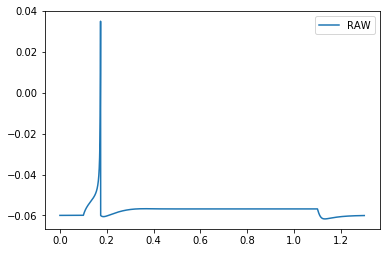

In [2]:

import pickle
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuronunit.optimization import get_neab
from neuronunit.models.reduced import ReducedModel


from neuronunit.optimization import optimization_management as om


import pickle

from neuronunit.models.reduced import ReducedModel

from neuronunit.optimization.model_parameters import model_params, path_params
LEMS_MODEL_PATH = path_params['model_path']
import neuronunit.optimization as opt
import quantities as pq


from neuronunit.optimization.data_transport_container import DataTC



model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
model.set_attrs(TC)

iparams = {}
iparams['injected_square_current'] = {}
iparams['injected_square_current']['amplitude'] = 82.08333333333333*pq.pA
#['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
DELAY = 100.0*pq.ms
DURATION = 1000.0*pq.ms
iparams['injected_square_current']['delay'] = DELAY
iparams['injected_square_current']['duration'] = int(DURATION)

model.inject_square_current(iparams)

plt.plot(model.get_membrane_potential().times,model.get_membrane_potential(),label='RAW')
plt.legend()
plt.show()

In [3]:

model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
model.set_attrs(TC)


tests_,all_tests, observation,suite = get_neab.get_tests()

rheobase = all_tests[0].generate_prediction(model)


Try 1: SubMax = 41.7; SupraMin = 83.3
Try 2: SubMax = 69.5; SupraMin = 76.4
Try 3: SubMax = 74.1; SupraMin = 75.2


In [4]:


def format_iparams(all_tests,rheobase):

    for t in all_tests[1:5]:
        DURATION = 500.0*pq.ms
        DELAY = 200.0*pq.ms

        obs = t.observation
        t.params = {}
        t.params['injected_square_current'] = {}
        t.params['injected_square_current']['delay']= DELAY
        t.params['injected_square_current']['duration'] = DURATION
        t.params['injected_square_current']['amplitude'] = -10*pq.pA
        
    for t in all_tests[-3::]:    
        t.params = {}
        DURATION = 1000.0*pq.ms
        DELAY = 100.0*pq.ms

        t.params['injected_square_current'] = {}
        t.params['injected_square_current']['delay']= DELAY
        t.params['injected_square_current']['duration'] = DURATION
        t.params['injected_square_current']['amplitude'] = rheobase['value']
    
    all_tests[0].params = all_tests[-1].params
    
    return all_tests

pt = format_iparams(all_tests,rheobase)
print([t.params['injected_square_current']['amplitude'] for t in pt[-3::] ])
print([t.params['injected_square_current']['amplitude'] for t in pt[0:5] ])



[array(75.23847222222223) * pA, array(75.23847222222223) * pA, array(75.23847222222223) * pA]
[array(75.23847222222223) * pA, array(-10.0) * pA, array(-10.0) * pA, array(-10.0) * pA, array(-10.0) * pA]


##
# * Get predictions from models.
## * Fake NeuroElectro Observations
## * Do roundtrip testing
##

In [5]:
predictions = []
import dask.bag as db
# The rheobase has been obtained seperately and cannot be db mapped.
# Nested DB mappings dont work.
ptbag = db.from_sequence(pt[1::])

def obtain_predictions(t):    
    model = None
    model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
    model.set_attrs(TC)
    return t.generate_prediction(model)
predictions = list(ptbag.map(obtain_predictions).compute())
predictions.insert(0,rheobase)
print(predictions)    


injected current seen:  {'duration': array(500.0) * ms, 'delay': array(200.0) * ms, 'amplitude': array(-10.0) * pA}
injected current seen:  {'duration': array(500.0) * ms, 'delay': array(200.0) * ms, 'amplitude': array(-10.0) * pA}
injected current seen:  {'duration': array(500.0) * ms, 'delay': array(200.0) * ms, 'amplitude': array(-10.0) * pA}
[{'value': array(75.23847222222223) * pA}, {'value': array(31739282.99824782) * kg*m**2/(s**3*A**2)}, {'value': array(0.0034631849083750876) * s}, {'value': array(1.0911352057216523e-10) * s**4*A**2/(kg*m**2)}, {'mean': array(-0.060317405613048956) * V, 'std': array(0.00019622743842309925) * V}, {'mean': array(0.0007) * s, 'std': array(0.0) * s, 'n': 1}, {'mean': array(0.059395212768064726) * V, 'std': array(0.0) * V, 'n': 1}, {'mean': array(-0.02439521276806472) * V, 'std': array(0.0) * V, 'n': 1}]


In [6]:
# having both means and values in dictionary makes it very irritating to iterate over.
# It's more harmless to demote means to values, than to elevate values to means.
# Simply swap key names: means, for values.
for p in predictions:
    if 'mean' in p.keys():
        p['value'] = p.pop('mean')
print(predictions)


[{'value': array(75.23847222222223) * pA}, {'value': array(31739282.99824782) * kg*m**2/(s**3*A**2)}, {'value': array(0.0034631849083750876) * s}, {'value': array(1.0911352057216523e-10) * s**4*A**2/(kg*m**2)}, {'value': array(-0.060317405613048956) * V, 'std': array(0.00019622743842309925) * V}, {'value': array(0.0007) * s, 'std': array(0.0) * s, 'n': 1}, {'value': array(0.059395212768064726) * V, 'std': array(0.0) * V, 'n': 1}, {'value': array(-0.02439521276806472) * V, 'std': array(0.0) * V, 'n': 1}]


In [7]:
# make some new tests based on internally generated data 
# as opposed to experimental data.


TC_tests = copy.copy(all_tests)
for ind,t in enumerate(TC_tests):
    if 'mean' in t.observation.keys():
        t.observation['value'] = t.observation.pop('mean')
    pred =  predictions[ind]['value']
    try:
        pred = pred.rescale(t.units)
        t.observation['value'] = pred
    except:        
        t.observation['value'] = pred
        #pq.set_default_units('SI')
        #t.observation['value'] = t.observation['value'].rescale(pq.pF)
    t.observation['mean'] = t.observation['value']
        
    print(t.observation['value'])



75.23847222222223 pA
31.73928299824782 Mohm
3.4631849083750876 ms
1.0911352057216523e-10 s**4*A**2/(kg*m**2)
-60.317405613048955 mV
0.7 ms
59.395212768064724 mV
-24.39521276806472 mV


In [8]:
def hack_judge(test_and_models):
    (test, attrs) = test_and_models
    model = None
    obs = test.observation
    model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
    model.set_attrs(attrs)
    test.generate_prediction(model)
    pred = test.generate_prediction(model)
    score = test.compute_score(obs,pred)
    try:
        print(obs['value'],pred['value'])
    except:
        print(obs['mean'],pred['mean'])
        
    return score

scores = []
for i,t in enumerate(TC_tests):
    test_and_models = (t,TC)
    score = hack_judge(test_and_models)
    scores.append(score)
print(scores[0].sort_key)    
print(scores[0])    



Try 1: SubMax = 41.7; SupraMin = 83.3
Try 2: SubMax = 69.5; SupraMin = 76.4
Try 3: SubMax = 74.1; SupraMin = 75.2
Try 1: SubMax = 41.7; SupraMin = 83.3
Try 2: SubMax = 69.5; SupraMin = 76.4
Try 3: SubMax = 74.1; SupraMin = 75.2
75.23847222222223 pA 75.23847222222223 pA
injected current seen:  {'duration': array(500.0) * ms, 'delay': array(200.0) * ms, 'amplitude': array(-10.0) * pA}
injected current seen:  {'duration': array(500.0) * ms, 'delay': array(200.0) * ms, 'amplitude': array(-10.0) * pA}
input resistance score: Z = 0.00
31.73928299824782 Mohm 31739282.99824782 kg*m**2/(s**3*A**2)
injected current seen:  {'duration': array(500.0) * ms, 'delay': array(200.0) * ms, 'amplitude': array(-10.0) * pA}
injected current seen:  {'duration': array(500.0) * ms, 'delay': array(200.0) * ms, 'amplitude': array(-10.0) * pA}
3.4631849083750876 ms 0.0034631849083750876 s
injected current seen:  {'duration': array(500.0) * ms, 'delay': array(200.0) * ms, 'amplitude': array(-10.0) * pA}
injected c

In [9]:
print([s.sort_key for s in scores])
print([s.score for s in scores])

score = hack_judge((TC_tests[-3],TC))
print(score)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999996]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.317017647578838e-16]
0.7 ms 0.0007 s
Z = 0.00


In [10]:
scores = []
for t in TC_tests:
    test_and_models = (t,RS)
    score = hack_judge(test_and_models)
    scores.append(score)
print(scores[0].sort_key)    
print(scores[0])
print([s.sort_key for s in scores])


Try 1: SubMax = 41.7; SupraMin = 83.3
Try 2: SubMax = 48.6; SupraMin = 55.6
Try 3: SubMax = 50.9; SupraMin = 52.1
Try 1: SubMax = 41.7; SupraMin = 83.3
Try 2: SubMax = 48.6; SupraMin = 55.6
Try 3: SubMax = 50.9; SupraMin = 52.1
75.23847222222223 pA 52.09125 pA
injected current seen:  {'duration': array(500.0) * ms, 'delay': array(200.0) * ms, 'amplitude': array(-10.0) * pA}
injected current seen:  {'duration': array(500.0) * ms, 'delay': array(200.0) * ms, 'amplitude': array(-10.0) * pA}
input resistance score: Z = 0.62
31.73928299824782 Mohm 79634016.52239381 kg*m**2/(s**3*A**2)
injected current seen:  {'duration': array(500.0) * ms, 'delay': array(200.0) * ms, 'amplitude': array(-10.0) * pA}
injected current seen:  {'duration': array(500.0) * ms, 'delay': array(200.0) * ms, 'amplitude': array(-10.0) * pA}
3.4631849083750876 ms 0.009810667396493434 s
injected current seen:  {'duration': array(500.0) * ms, 'delay': array(200.0) * ms, 'amplitude': array(-10.0) * pA}
injected current see

In [11]:
predictions = []
import dask.bag as db
# The rheobase has been obtained seperately and cannot be db mapped.
# Nested DB mappings dont work.
test_a_models = zip(TC_tests[1::],RS)
tc_bag = db.from_sequence(test_a_models)

scores = list(tc_bag.map(hack_judge).compute())
scores.insert(0,rheobase)
print(scores)    

TypeError: set_attrs() argument after ** must be a mapping, not str

In [ ]:
score = TC_tests[0].judge(model,stop_on_error = False, deep_error = True)
print(score.prediction)
#print(model.get_spike_count())

In [ ]:
from neuronunit.optimization import optimization_management as opt
from neuronunit.models import ReducedModel

In [ ]:

cnt = 0
scores = []
tests_,all_tests, observation,suite = opt.get_neab.get_tests()
passive  = [ str('RestingPotentialTest'), str('CapacitanceTest'), str('TimeConstantTest'), str('InputResistanceTest') ]
firing_tests =  [ t for t in all_tests if str(t) not in passive ]
first_two = all_tests[0:2]
print(first_two)

for t in all_tests:
    score = t.judge(model,stop_on_error = False, deep_error = True)
    scores.append(score)
    print(score)
    print('score {0}'.format(score))
    if str('mean') in score.prediction.keys():
        print('observation {0}, prediction {1}'.format(t.observation['mean'],score.prediction['mean']))
    if str('value') in score.prediction.keys():
        print('observation {0}, prediction {1}'.format(t.observation['mean'],score.prediction['value']))
    cnt+=1
#http://www.physics